# Supervised Learning with a Parameterized Quantum Circuit 

In supervised learning the goal is to learn a function that maps given inputs to their corresponding outputs (i.e., their labels), based on example input-output pairs (i.e., the training data).


Within the course, you have seen the following diagram representing a typical Quantum Machine Learning situation with classical data:
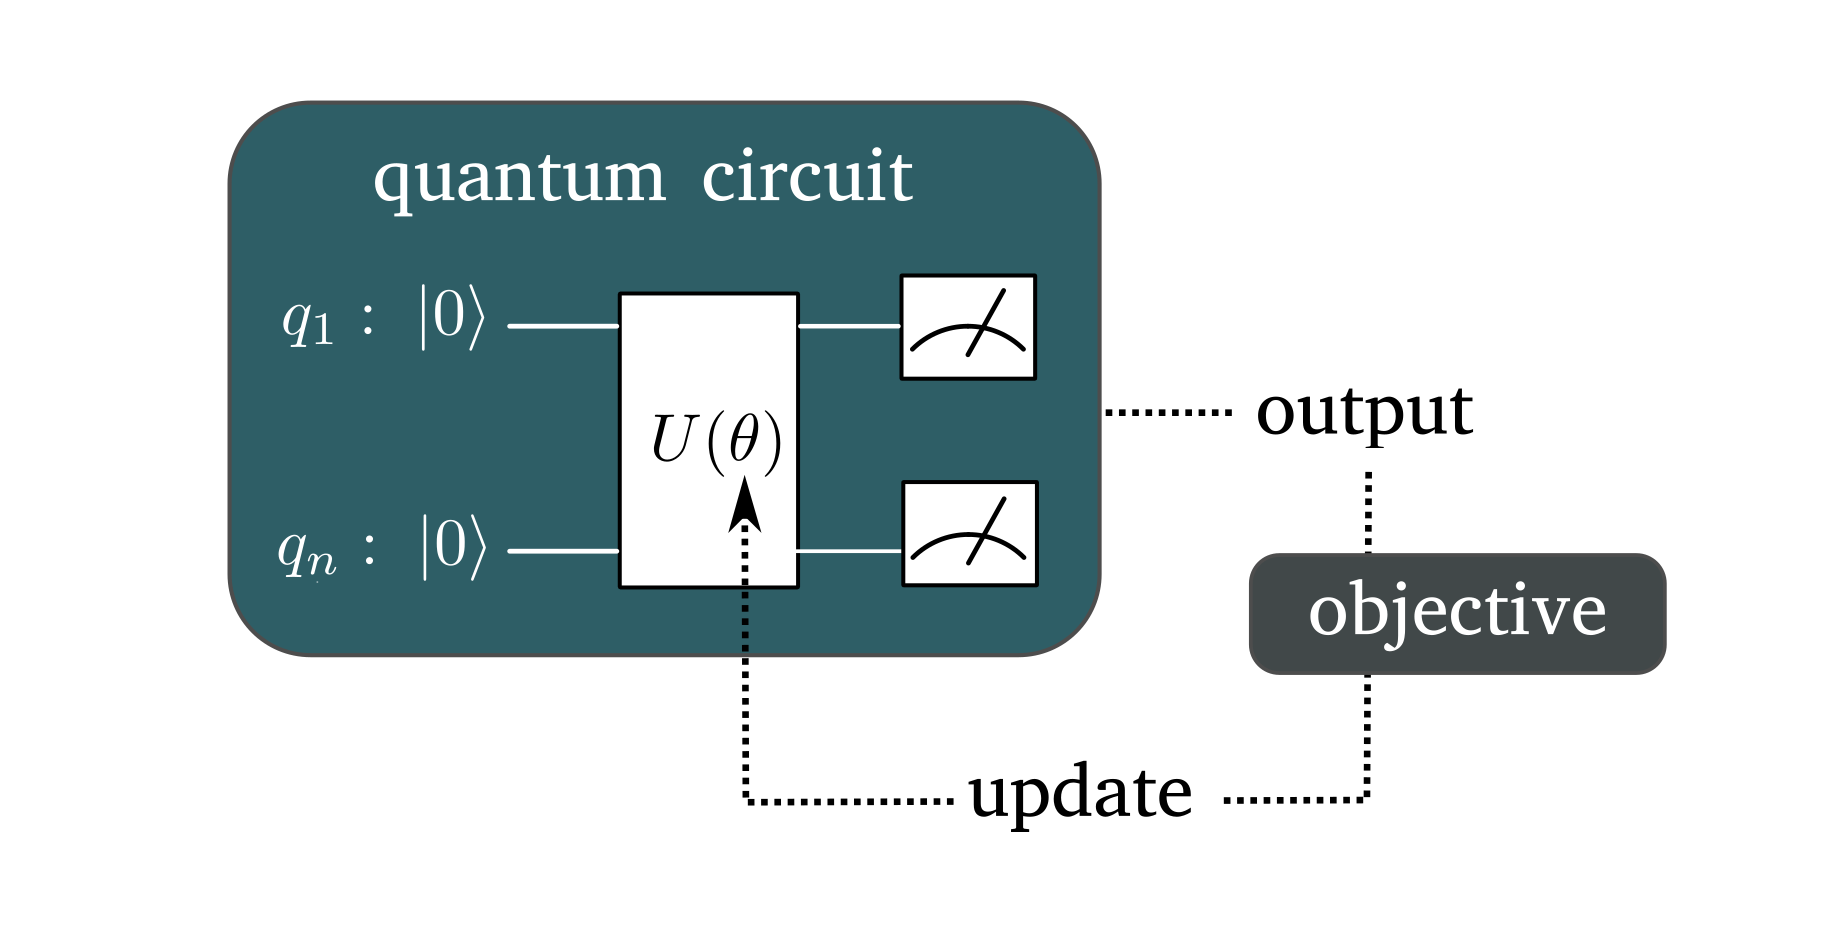


The quantum circuit in the above diagram is defined by two quantum circuits. First, we have a so-called ``encoding circuit`` that is used to encode the classical data into a quantum circuit. Secondly, we have a so-called ``variational circuit`` that dependends on real parameters which are tweaked by a classical optimizater in order to best classify the training examples. 

In this notebook we implement the above diagram to learn a toy-dataset, explaining each step along the way.

In [1]:
# !pip install cirq
from scipy.optimize import minimize

import cirq
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

%matplotlib inline

## I. Generating the data

We generate a random 2D binary classification dataset consisting of points in a square, which +1 labels if they lie within a circle.

In [2]:
# Set a random seed
np.random.seed(42)

# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float): radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)

# Plot the above dataset
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array): array of data points 
        y (array[int]): array of data points labels
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

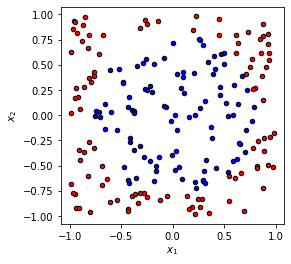

In [3]:
X, Y = circle(200)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(X, Y, fig=fig, ax=ax)
plt.show()

## II. Adding an extra feature to the data 

Often in Machine Learning, we transform the data before feeding to a model. 

For more information on this topic see: https://scikit-learn.org/stable/data_transforms.html

Here, we add another feature, namely the product of the x1 & x2 coordinate.

In [6]:
data = np.empty((X.shape[0],X.shape[1]+1))
data[:,:2] = X
data[:,-1] = X[:,0]*X[:,1]

# print(data)

## III. Split into train/validation

In Machine Learning, the goal is to build a model that generalizes well -- i.e., performance should also be good on unseen data. 

One way to benchmark this is to split the data into a training set and a validation set.

In [7]:
data_train, data_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.5, random_state=42, stratify=Y)

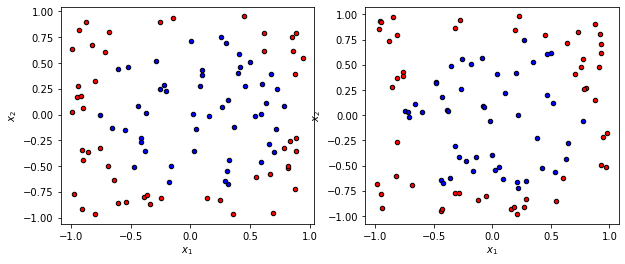

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_data(data_train, Y_train, fig=fig, ax=ax[0])
plot_data(data_test, Y_test, fig=fig, ax=ax[1])
plt.show()

## IV. Constructing the parameterized quantum circuit model

### 1. Setting a few hyperparameters 

We use 3 qubits (i.e., one qubit per feature). 

``n_layers`` is the number of times we apply the variational circuit.

In [9]:
# Circuit hyperparameters
n_qubits = 3
n_layers = 5

# Create a register of qubits
qubits = cirq.LineQubit.range(n_qubits)   

# Initialize simulator
simulator = cirq.Simulator()

# initial parameters 
n_params = n_qubits * n_layers

np.random.seed(42)
theta0 = np.random.uniform(-2*np.pi, 2*np.pi, size=n_params)

print("Number of parameters to optimize: ",n_params)
print(theta0)

Number of parameters to optimize:  15
[-1.57657536  5.66384302  2.91532185  1.23977908 -4.32259725 -4.32290035
 -5.55328511  4.60150516  1.27064871  2.61471713 -6.02451292  5.90506136
  4.17759743 -3.61485335 -3.99830538]


### 2. Create the function yielding the circuit

We will set the data preparation circuit to be a layer of RZ-RY-RZ operations and input the data as angles of the layer.

For the parameterized circuit, we will use a layer of RX rotation followed by an entangling layer of CZs. 

In [10]:
# Encoding layer that uses x_i as angles to encode data.
def encoding_circuit(x_i):
    ## TODO: write code that generates the following circuit:
    # - Apply Rz(x_i[j])-Ry(x_i[j])-Rz(x_i[j]) to qubit j.
    yield [cirq.rz(x_i[j])(q) for j, q in enumerate(qubits)]
    yield [cirq.ry(x_i[j])(q) for j, q in enumerate(qubits)]
    yield [cirq.rz(x_i[j])(q) for j, q in enumerate(qubits)]

# Variational layers of Rx and linearly-connected Cz
def variational_circuit(params):
    ## TODO: write code that generates the following circuit:
    # - Apply n_layers times the following sequence of gates.
    #    * parameterized rx gate on each qubit.
    #    * followed by CZ-gate between each neighbouring qubit.
    for l in range(n_layers):
        yield [cirq.rx(p)(qubits[i]) for i, p in enumerate(params[3*l:3*l+2+1])]
        yield [cirq.CZ(q, qubits[i+1]) for i, q in enumerate(qubits[:-1])]
    
# Concatenate encoding and variational circuit.
def qml_classifier_circuit(params, x_i):
    return cirq.Circuit(encoding_circuit(x_i), variational_circuit(params))
        
initial_circuit = qml_classifier_circuit(theta0, data[0,:])
print("First instance : ")
print(data[0,:])
print("Divided by pi: ",data[0,:] / np.pi,"\n")

print("Initial params : ")
print(theta0)
print("Divided by pi: ",theta0 / np.pi,"\n")

print(initial_circuit.to_text_diagram(transpose=True))

First instance : 
[-0.25091976  0.90142861 -0.22618625]
Divided by pi:  [-0.07987024  0.28693364 -0.07199732] 

Initial params : 
[-1.57657536  5.66384302  2.91532185  1.23977908 -4.32259725 -4.32290035
 -5.55328511  4.60150516  1.27064871  2.61471713 -6.02451292  5.90506136
  4.17759743 -3.61485335 -3.99830538]
Divided by pi:  [-0.50183952  1.80285723  0.92797577  0.39463394 -1.37592544 -1.37602192
 -1.76766555  1.46470458  0.40446005  0.83229031 -1.91766202  1.87963941
  1.32977056 -1.15064356 -1.27270013] 

0           1          2
│           │          │
Rz(-0.08π)  Rz(0.287π) Rz(-0.072π)
│           │          │
Ry(-0.08π)  Ry(0.287π) Ry(-0.072π)
│           │          │
Rz(-0.08π)  Rz(0.287π) Rz(-0.072π)
│           │          │
Rx(-0.502π) Rx(1.8π)   Rx(0.928π)
│           │          │
@───────────@          │
│           │          │
Rx(0.395π)  @──────────@
│           │          │
│           Rx(-1.38π) Rx(-1.38π)
│           │          │
@───────────@          │
│          

### 3. Specify the output for binary classification

In our case, we will use the norm of the amplitude of the all-one string to decide on the label of the data. 

More precisely, if this probablity is above 0.5, then we say that the data has to be labeled 1.

In [11]:
# Determine the relevant output of the circuit
def run_circuit(params, x_i):
    ## TODO: write function that outputs the norm of the amplitude of |11...1>.
    circuit = qml_classifier_circuit(params, x_i)
    result = simulator.simulate(circuit)
    all_ones = result.final_state_vector[-1]
    return abs(all_ones)

run_circuit(theta0, data[0,:])

0.1955713

### 4. Set the loss function to optimize

Our circuit will take look at the given training examples one by one. After sweeping the entire dataset, we compute a loss function, characterizing the performance of our model. We use the mean squared error, which is the cost function that we pass to the classical optimizer.

In [12]:
# Compute output of circuit on entire dataset.
def sweep_data(params,X):
    probs = [run_circuit(params,X[i,:]) for i in range(X.shape[0])]
    return probs

# Based on output of the circuit, compute the loss.
def compute_loss(params, X, labels):
    ## TODO: write loss function that achieves the following:
    #  - when minimized, the QML-classifier correctly labels the data.
    # HINTs:  * what should the output probability of circuit be given the label?
    #         * you can use the function mean_squared_error.
    predictions = sweep_data(params, X)
    return mean_squared_error(predictions, labels)

# Save the current cost, and accuracies to plot later
tracking_cost = []

# Loss function to pass to classical optimizer
def cost_to_optimize(params):
    cost = compute_loss(params, data_train, Y_train)
    tracking_cost.append(cost)
    return cost


## IV. Learning

Now is the time to optimize the parameters of the model for classification. We will use a simple derivative-free optimizer called COBYLA.

In [13]:
from time import time
start_time = time()
final_params = minimize(cost_to_optimize, theta0, method="COBYLA", options={"maxiter":80})
end_time = time()
print(end_time-start_time)

44.64921522140503


In [14]:
final_params

     fun: 0.17225459530730042
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 80
  status: 2
 success: False
       x: array([-1.56937265,  6.51387112,  3.39594675,  0.88684172, -4.66499481,
       -4.31200159, -5.55653909,  4.77635781,  0.94493513,  4.17536297,
       -6.26158   ,  5.65386184,  3.64101782, -3.78030833, -2.91384967])

## V. Performances

Let us see the performance of our model! 

To do so, we define the ``predict`` function, which converts the output probabilities of the circuit to the binary labels of our dataset.

In [15]:
def predict(params,X):
    probas = sweep_data(params,X)
    return np.array([1 if p > .5 else 0 for p in probas])

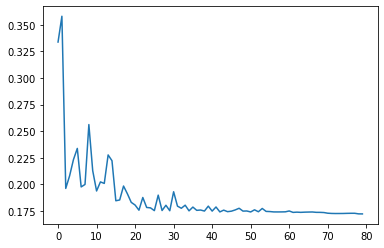

In [16]:
plt.plot(list(range(len(tracking_cost))), tracking_cost)
plt.show()

In [17]:
# before training
print("Accuracy on training set: ", accuracy_score(Y_train,predict(theta0,data_train)))
print("Accuracy on validation set: ", accuracy_score(Y_test,predict(theta0,data_test)))

Accuracy on training set:  0.5
Accuracy on validation set:  0.51


In [18]:
# after training
print("Accuracy on training set: ", accuracy_score(Y_train,predict(final_params.x,data_train)))
print("Accuracy on validation set: ", accuracy_score(Y_test,predict(final_params.x,data_test)))

Accuracy on training set:  0.96
Accuracy on validation set:  0.89


Let us visualize the results now!

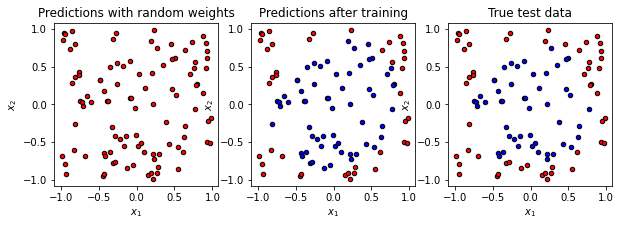

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(data_test, predict(theta0, data_test), fig, axes[0])
plot_data(data_test, predict(final_params.x, data_test), fig, axes[1])
plot_data(data_test, Y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.show()